## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [3]:
%%HTML
<style> code {background-color : pink !important;} </style>

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
print (images)

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

['camera_cal\\calibration1.jpg', 'camera_cal\\calibration10.jpg', 'camera_cal\\calibration11.jpg', 'camera_cal\\calibration12.jpg', 'camera_cal\\calibration13.jpg', 'camera_cal\\calibration14.jpg', 'camera_cal\\calibration15.jpg', 'camera_cal\\calibration16.jpg', 'camera_cal\\calibration17.jpg', 'camera_cal\\calibration18.jpg', 'camera_cal\\calibration19.jpg', 'camera_cal\\calibration2.jpg', 'camera_cal\\calibration20.jpg', 'camera_cal\\calibration3.jpg', 'camera_cal\\calibration4.jpg', 'camera_cal\\calibration5.jpg', 'camera_cal\\calibration6.jpg', 'camera_cal\\calibration7.jpg', 'camera_cal\\calibration8.jpg', 'camera_cal\\calibration9.jpg']


## And so on and so forth...

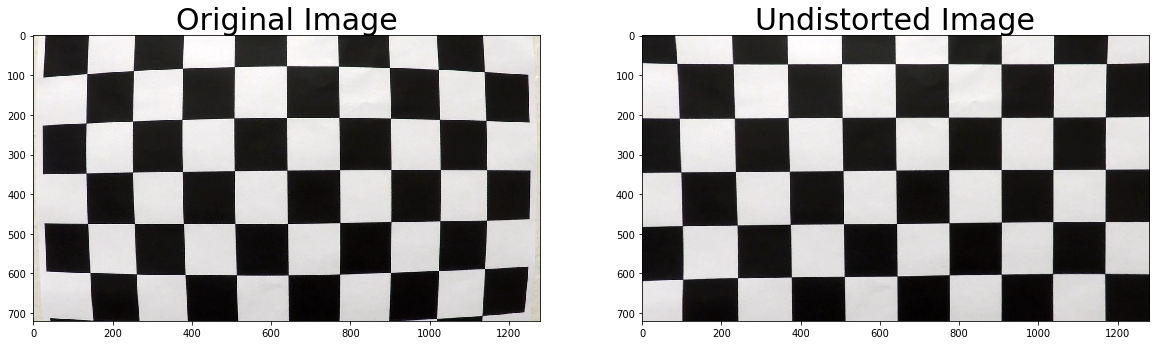

In [5]:
%matplotlib inline

# Test undistortion on an image
img = mpimg.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

#applied this distortion correction to the test image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('image1.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

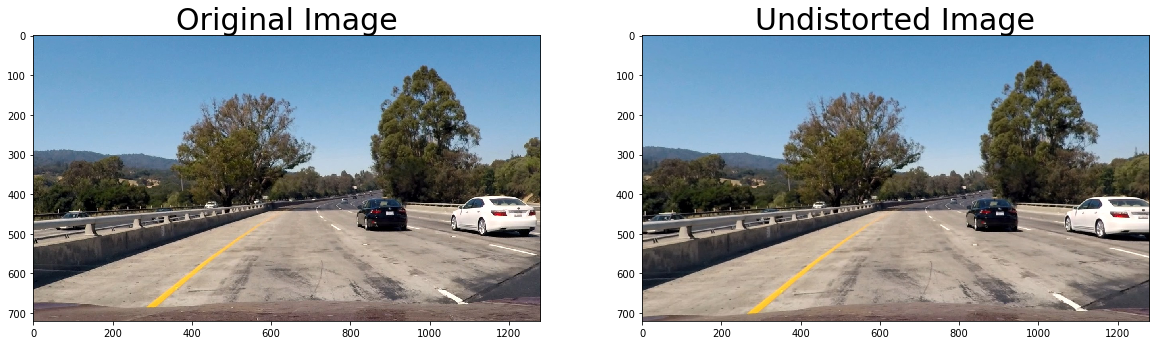

In [6]:
%matplotlib inline

# Test undistortion on an image
img = mpimg.imread('test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

#applied this distortion correction to the test image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [7]:
# image pipeline
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    # Grayscale image
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

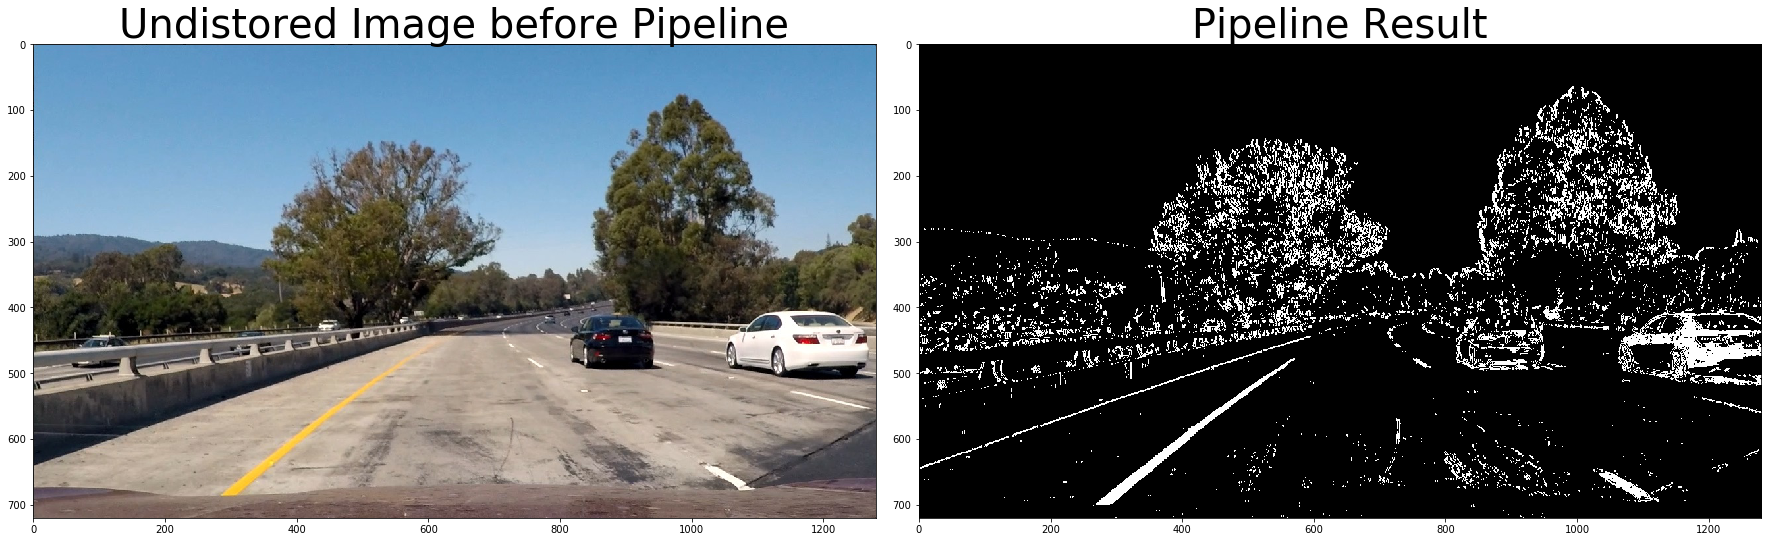

In [8]:
# Test undistortion on an image
#img = mpimg.imread('test_images/test1.jpg')
#img_size = (img.shape[1], img.shape[0])
result = pipeline(dst)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
mpimg.imsave('image2.png',img)
ax1.set_title('Undistored Image before Pipeline', fontsize=40)

ax2.imshow(result, cmap='gray')
mpimg.imsave('image3.png',result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40,)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [9]:
# Perspective Transform
def warper(img, nx, ny, mtx, dist):
    # remove distortion
#    img = cv2.undistort(img, mtx, dist, None, mtx)
#    undist = np.copy(img)  
    # Convert to grayscale
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#    img_size = (gray.shape[1], gray.shape[0])
    width = img.shape[1]
    height = img.shape[0]
    src = np.array([[(width*0.4, height*0.65),
                        (width*0.6, height*0.65),
                        (width, height),
                        (0, height)]], 
                        dtype=np.float32)
    dst = np.array([[0,0], 
                    [img.shape[1], 0], 
                    [img.shape[1], img.shape[0]],
                    [0, img.shape[0]]],
                    dtype = 'float32') 
    # get the transform matrix
    M = cv2.getPerspectiveTransform(src, dst) 
    # Inverse Transform
    M_inv = cv2.getPerspectiveTransform(dst, src) 
    # warp image to a top-down view
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M, M_inv,src,dst

src [[[  512.   468.]
  [  768.   468.]
  [ 1280.   720.]
  [    0.   720.]]]
dst [[    0.     0.]
 [ 1280.     0.]
 [ 1280.   720.]
 [    0.   720.]]


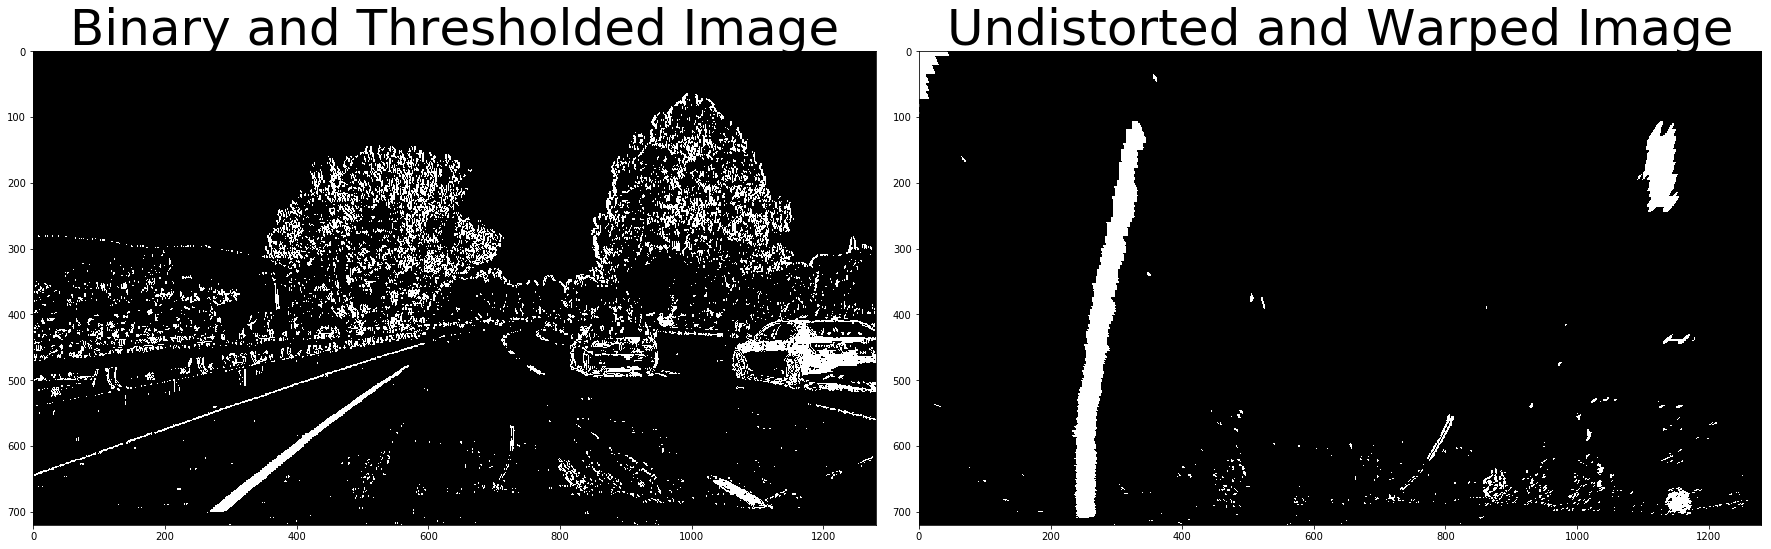

In [10]:
top_down, perspective_M, M_inv,src,dst = warper(result, nx, ny, mtx, dist)
print ('src',src)
print ('dst',dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result, cmap='gray')
ax1.set_title('Binary and Thresholded Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

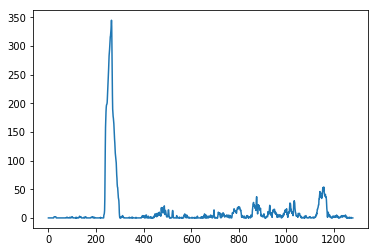

In [11]:
# Line Finding Method: Peaks in a Histogram
import numpy as np
def test(top_down):
    histogram = np.sum(top_down[top_down.shape[0]//2:,:], axis=0)
    return histogram

histogram = test(top_down)
plt.plot(histogram)

In [12]:
# Implement Sliding Windows and Fit a Polynomial
def sliding_windows(binary_warped):
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]    
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit 

(720, 0)

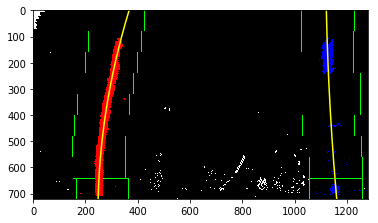

In [13]:
# Generate x and y values for plotting
binary_warped = top_down
out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = sliding_windows(binary_warped)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [14]:
# search in a margin around the previous line position with a new warped binary image 
# from the next frame of video (also called "binary_warped")

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

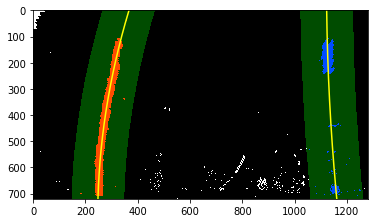

In [15]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [16]:
# Measuring Curvature
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

num_rows = top_down.shape[0]
left_curve_rad = measure_radius_of_curvature(left_fitx)
right_curve_rad = measure_radius_of_curvature(right_fitx)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (right_fitx[719] + left_fitx[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Radius of curvature: 1864.89 m
Center offset: 0.34 m


In [17]:
# Add some calculations on the images, such as curvature and deviation (position from center)
def add_calculation_image(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

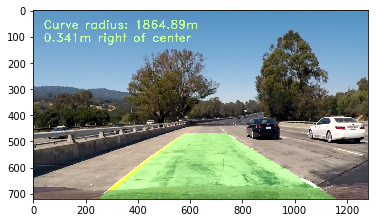

In [18]:
# Combine the processed image with the original image.
warped = top_down
out_img = np.dstack((warped, warped, warped))*255
y_points = np.linspace(0, num_rows-1, num_rows)
left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
line_points = np.vstack((left_line_window, right_line_window))
cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
result = add_calculation_image(result, average_curve_rad, center_offset_mtrs)
plt.imshow(result)

In [19]:
# Construct image Pipeline for general images. 
def process_image(image):
    img = image
    img_size = (img.shape[1], img.shape[0])
    #applied this distortion correction to the test image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    result = pipeline(dst)    
    top_down, perspective_M, M_inv, src, dst = warper(result, nx, ny, mtx, dist)
    binary_warped = top_down
    # sliding widnow
    out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = sliding_windows(binary_warped)

    # search in a margin around the previous line position with a new warped binary image 
    # from the next frame of video (also called "binary_warped")

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    num_rows = top_down.shape[0]
    left_curve_rad = measure_radius_of_curvature(left_fitx)
    right_curve_rad = measure_radius_of_curvature(right_fitx)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2


    # compute the offset from the center
    lane_center = (right_fitx[719] + left_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels


    # Combine the processed image with the original image.
    out_img = np.dstack((warped, warped, warped))*255
    y_points = np.linspace(0, num_rows-1, num_rows)
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
    line_points = np.vstack((left_line_window, right_line_window))
    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    result = add_calculation_image(result, average_curve_rad, center_offset_mtrs)
    return result

['test_images\\straight_lines1.jpg', 'test_images\\straight_lines2.jpg', 'test_images\\test1.jpg', 'test_images\\test2.jpg', 'test_images\\test3.jpg', 'test_images\\test4.jpg', 'test_images\\test5.jpg', 'test_images\\test6.jpg']


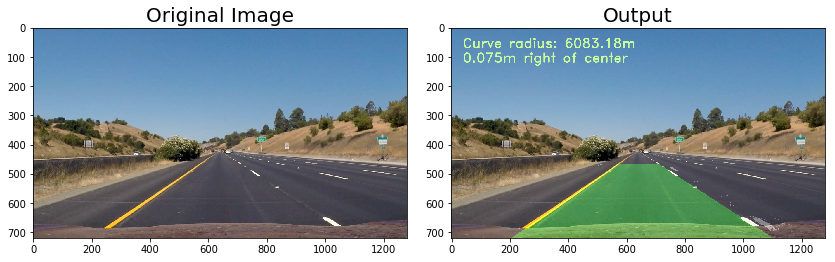

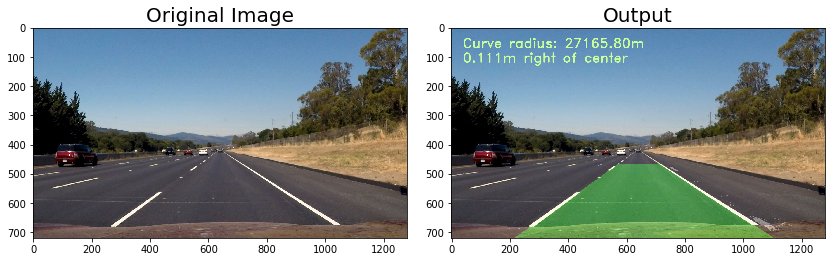

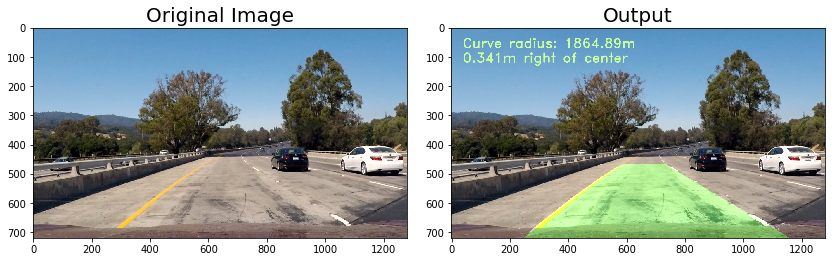

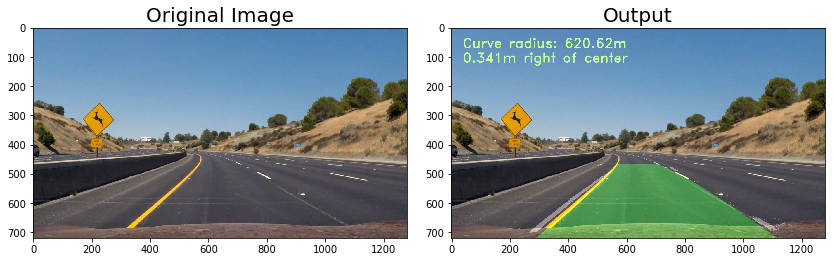

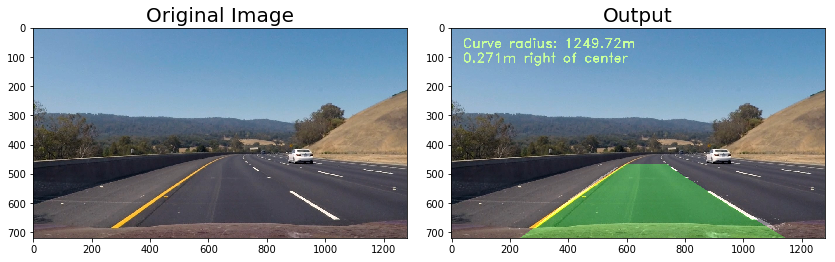

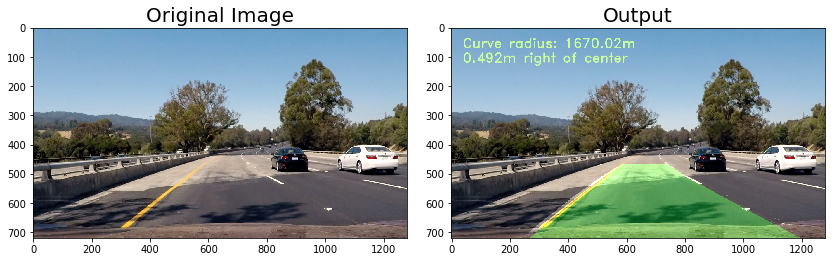

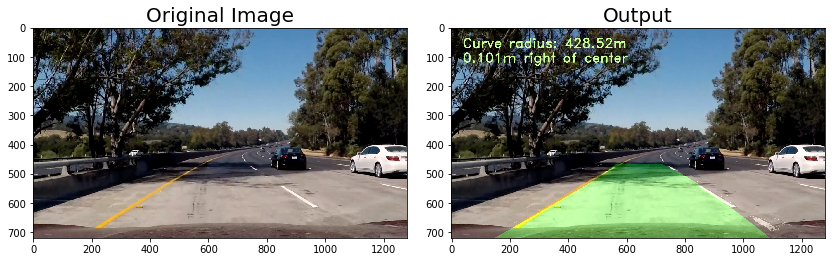

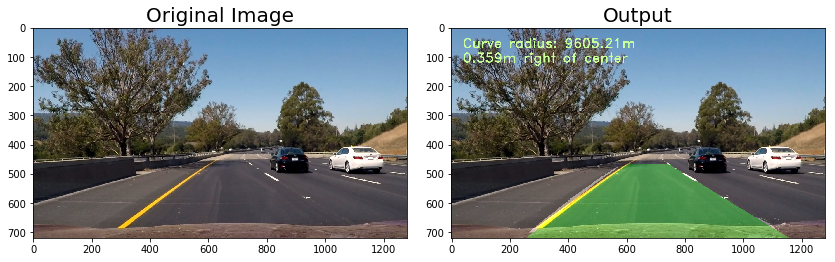

In [20]:
# draw detected lane lines on all test images
import os
#image = mpimg.imread('test_images/test3.jpg')
test_images = glob.glob('test_images/*.jpg')
print(test_images)

images = os.listdir('./test_images')  
for fname in images:
    fname = os.path.join('test_images',fname)
    image = mpimg.imread(fname)
    result = process_image(image)
           
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(result)
    ax2.set_title('Output', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# draw detected lane lines on the video (all frames kept)
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#for image in clip2.iter_frames():
# video output
write_output = 'project_video_out.mp4'
# video input 
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(process_image) 
%time write_clip.write_videofile(write_output, audio=False)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'sample_out.mp4'
subclip = VideoFileClip("project_video.mp4").subclip(41, 43)
write_clip = subclip.fl_image(process_image) 
%time write_clip.write_videofile(write_output, audio=False)

In [21]:
# Corrected image processing pipeline
# implementing a sanity checking to find bad frames and avoid large deviation of detected lanes on some frames
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #x values in windows
        self.windows = np.ones((3,12))*-1

In [22]:
# Main corrected image processing pipeline
def pipeline1(img):     
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Define sobel kernel size
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    # Defining vertices for marked area
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(color_binary, vertices)
    return color_binary

def process_image1(image):
    # Apply pipeline to the image to create black and white image
    img = pipeline1(image)
    # Warp the image to make lanes parallel to each other
    top_down, perspective_M, perspective_Minv = corners_unwarp(img, nx, ny, mtx, dist)
    # Find the lines fitting to left and right lanes
    a, b, c, lx, ly, rx, ry, curvature = fit_lanes(top_down)
    # Return the original image with colored region
    return draw_poly(image, top_down, a, b, c, lx, ly, rx, ry, perspective_Minv, curvature, img)

In [23]:
import math
# Calculate directional gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient magnitude
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

def region_of_interest(img, vertices):
    """
    Applies an image mask to keep a region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask = np.zeros_like(img)   
    
    #define 3-channel or 1-channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Choose an offset from image corners to plot detected corners
    offset1 = 200 # offset for dst points x value
    offset2 = 0 # offset for dst points bottom y value
    offset3 = 0 # offset for dst points top y value
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32(area_of_interest)
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    dst = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped, M, Minv

def fit_lanes(image):
    # define y coordinate values for plotting
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    # find the coordinates from the image
    lanes = np.argwhere(image)
    # Coordinates for left lane
    left_lane_x = []
    left_lane_y = []
    # Coordinates for right lane
    right_lane_x = []
    right_lane_y = []
    # Curving left or right - -1: left 1: right
    curve = 0
    # Set left and right as None
    left = None
    right = None
    # Find lanes from three repeated procedures with different window values
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(4, image, 25, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 0)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(6, image, 50, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 1)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(8, image, 75, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 2)
    # Find the coefficients of polynomials
    left_fit = np.polyfit(left_lane_y, left_lane_x, 2)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fit = np.polyfit(right_lane_y, right_lane_x, 2)
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    # Find curvatures
    left_curverad  = find_curvature(yvals, left_fitx)
    right_curverad = find_curvature(yvals, right_fitx)
    # Sanity check for the lanes
    left_fitx  = sanity_check(left_lane, left_curverad, left_fitx, left_fit)
    right_fitx = sanity_check(right_lane, right_curverad, right_fitx, right_fit)
    
    return yvals, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, right_lane_y, left_curverad

# find_lanes function will detect left and right lanes from the warped image.
# 'n' windows will be used to identify peaks of histograms    
def find_lanes(n, image, x_window, lanes, \
               left_lane_x, left_lane_y, right_lane_x, right_lane_y, window_ind):
    # 'n' windows will be used to identify peaks of histograms
    # Set index1. This is used for placeholder.
    index1 = np.zeros((n+1,2))
    index1[0] = [300, 1100]
    index1[1] = [300, 1100]
    # Set the first left and right values
    left, right = (300, 1100)
    # Set the center
    center = 700
    # Set the previous center
    center_pre = center
    # Set the direction
    direction = 0
    for i in range(n-1):
        # set the window range.
        y_window_top = 720-720/n*(i+1)
        y_window_bottom = 720-720/n*i
        # If left and right lanes are detected from the previous image
        if (left_lane.detected==False) and (right_lane.detected==False):
            # Find the historgram from the image inside the window
            left  = find_peaks(image, y_window_top, y_window_bottom, index1[i+1,0]-200, index1[i+1,0]+200)
            right = find_peaks(image, y_window_top, y_window_bottom, index1[i+1,1]-200, index1[i+1,1]+200)
            # Set the direction
            left  = sanity_check_direction(left, index1[i+1,0], index1[i,0])
            right = sanity_check_direction(right, index1[i+1,1], index1[i,1]) 
            # Set the center
            center_pre = center
            center = (left + right)/2
            direction = center - center_pre
        # If both lanes were detected in the previous image
        # Set them equal to the previous one
        else:
            left  = left_lane.windows[window_ind, i]
            right = right_lane.windows[window_ind, i]
        # Make sure the distance between left and right laens are wide enough
        if abs(left-right) > 600:
            # Append coordinates to the left lane arrays
            left_lane_array = lanes[(lanes[:,1]>=left-x_window) & (lanes[:,1]<left+x_window) &
                                 (lanes[:,0]<=y_window_bottom) & (lanes[:,0]>=y_window_top)]
            left_lane_x += left_lane_array[:,1].flatten().tolist()
            left_lane_y += left_lane_array[:,0].flatten().tolist()
            if not math.isnan(np.mean(left_lane_array[:,1])):
                left_lane.windows[window_ind, i] = np.mean(left_lane_array[:,1])
                index1[i+2,0] = np.mean(left_lane_array[:,1])
            else:
                index1[i+2,0] = index1[i+1,0] + direction
                left_lane.windows[window_ind, i] = index1[i+2,0]
            # Append coordinates to the right lane arrays            
            right_lane_array = lanes[(lanes[:,1]>=right-x_window) & (lanes[:,1]<right+x_window) &
                                  (lanes[:,0]<y_window_bottom) & (lanes[:,0]>=y_window_top)]
            right_lane_x += right_lane_array[:,1].flatten().tolist()
            right_lane_y += right_lane_array[:,0].flatten().tolist()
            if not math.isnan(np.mean(right_lane_array[:,1])):
                right_lane.windows[window_ind, i] = np.mean(right_lane_array[:,1])
                index1[i+2,1] = np.mean(right_lane_array[:,1])
            else:
                index1[i+2,1] = index1[i+1,1] + direction
                right_lane.windows[window_ind, i] = index1[i+2,1]
    return left_lane_x, left_lane_y, right_lane_x, right_lane_y

def find_peaks(image, y_window_top, y_window_bottom, x_left, x_right):
    # Find the historgram from the image inside the window
    y_window_top = int(y_window_top)
    y_window_bottom = int(y_window_top)
    histogram = np.sum(image[y_window_top:y_window_bottom,:], axis=0)
    # Find the max from the histogram
    if len(histogram[int(x_left):int(x_right)])>0:
        return np.argmax(histogram[int(x_left):int(x_right)]) + x_left
    else:
        return (x_left + x_right) / 2 
# Calculate gradient direction
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    # Return the result
    return dir_binary
def find_position(pts):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = image.shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix

In [24]:
from scipy.signal import find_peaks_cwt
# Define the region
area_of_interest = [[150+430,460],[1150-440,460],[1150,720],[150,720]]

# Sanity check for the direction
def sanity_check_direction(right, right_pre, right_pre2):
    # If the direction is ok then pass
    if abs((right-right_pre) / (right_pre-right_pre2) - 1) < .2:
        return right
    # If not then compute the value from the previous values
    else:
        return right_pre + (right_pre - right_pre2)
    
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

def sanity_check(lane, curverad, fitx, fit):       
    # Sanity check for the lane
    if lane.detected: # If lane is detected
        # If sanity check passes
        if abs(curverad / lane.radius_of_curvature - 1) < .6:        
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)            
            lane.radius_of_curvature = curverad
            lane.current_fit = fit
        # If sanity check fails use the previous values
        else:
            lane.detected = False
            fitx = lane.allx
    else:
        # If lane was not detected and no curvature is defined
        if lane.radius_of_curvature: 
            if abs(curverad / lane.radius_of_curvature - 1) < 1:            
                lane.detected = True
                lane.current_fit = fit
                lane.allx = fitx
                lane.bestx = np.mean(fitx)            
                lane.radius_of_curvature = curverad
                lane.current_fit = fit
            else:
                lane.detected = False
                fitx = lane.allx      
        # If curvature was defined
        else:
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)
            lane.radius_of_curvature = curverad
    return fitx

In [25]:
def draw_poly(image, warped, yvals, left_fitx, right_fitx, 
              left_lane_x, left_lane_y, right_lane_x, right_lane_y, Minv, curvature, img):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(result,text,(40,70), font, 1.5,(200,255,155),2)
    # Find the position of the car
    pts = np.argwhere(newwarp[:,:,1])
    position = find_position(pts)
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result,text,(40,70), font, 1.5,(200,255,155),2)
    
    # assemble the screen example
    img = (img/np.max(img)*255)
    warped = (warped/np.max(warped)*255)
    
    img_stacked = np.dstack((img, img, img))
    warped_stacked = np.dstack((warped, warped, warped))
    
    pts_left = pts_left.reshape((-1,1,2))
    pts_right = pts_right.reshape((-1,1,2))    
    
    # draw lines on image
    # Left Lane
    start = 0
    for line in pts_left:
        if start == 0:
            first_line = line
            start = 1
        else:
            end_line = line
            cv2.line(warped_stacked, (int(first_line[0][0]),int(first_line[0][1])),
                     (int(end_line[0][0]),int(end_line[0][1])), [0,255,0], 15)
            start = 0
    # Right Lane
    start = 0
    for line in pts_right:
        if start == 0:
            first_line = line
            start = 1
        else:
            end_line = line
            cv2.line(warped_stacked, (int(first_line[0][0]),int(first_line[0][1])),
                     (int(end_line[0][0]),int(end_line[0][1])), [0,0,255], 15)
            start = 0
            
    combined = np.zeros((720, 1920, 3), dtype=np.uint8)
    combined = result
    return combined

C:\Users\Asuku\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\Asuku\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Asuku\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


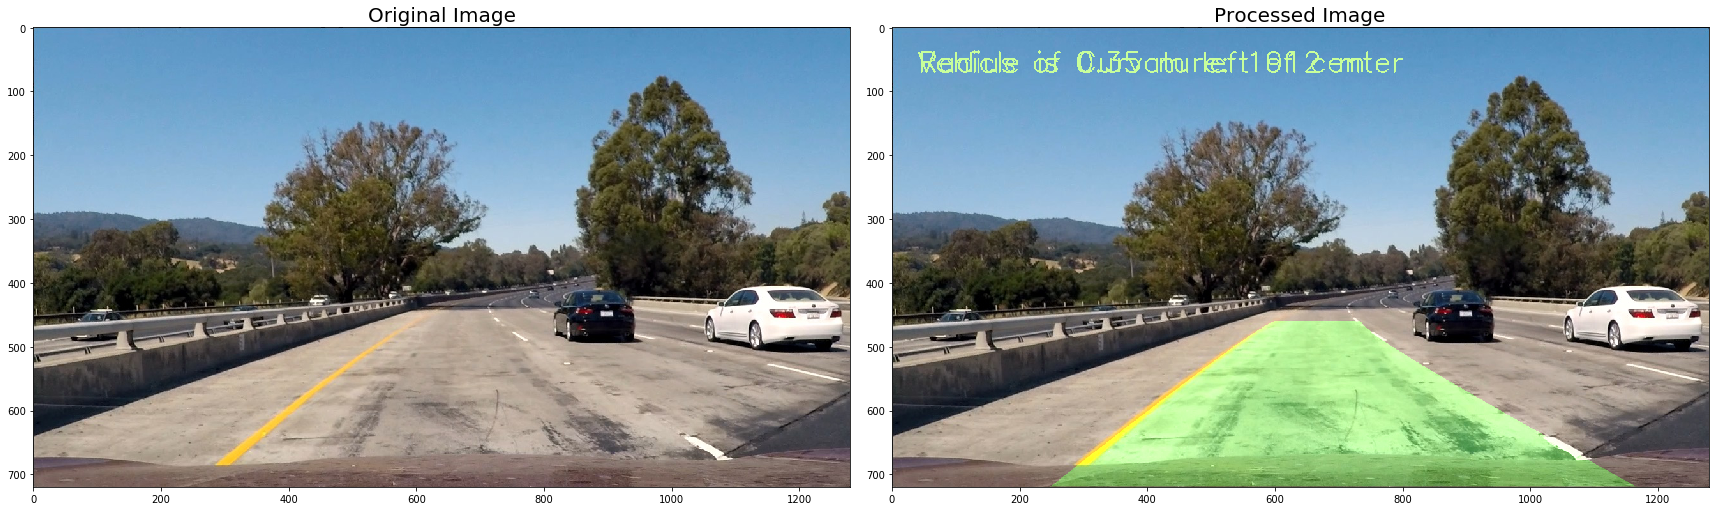

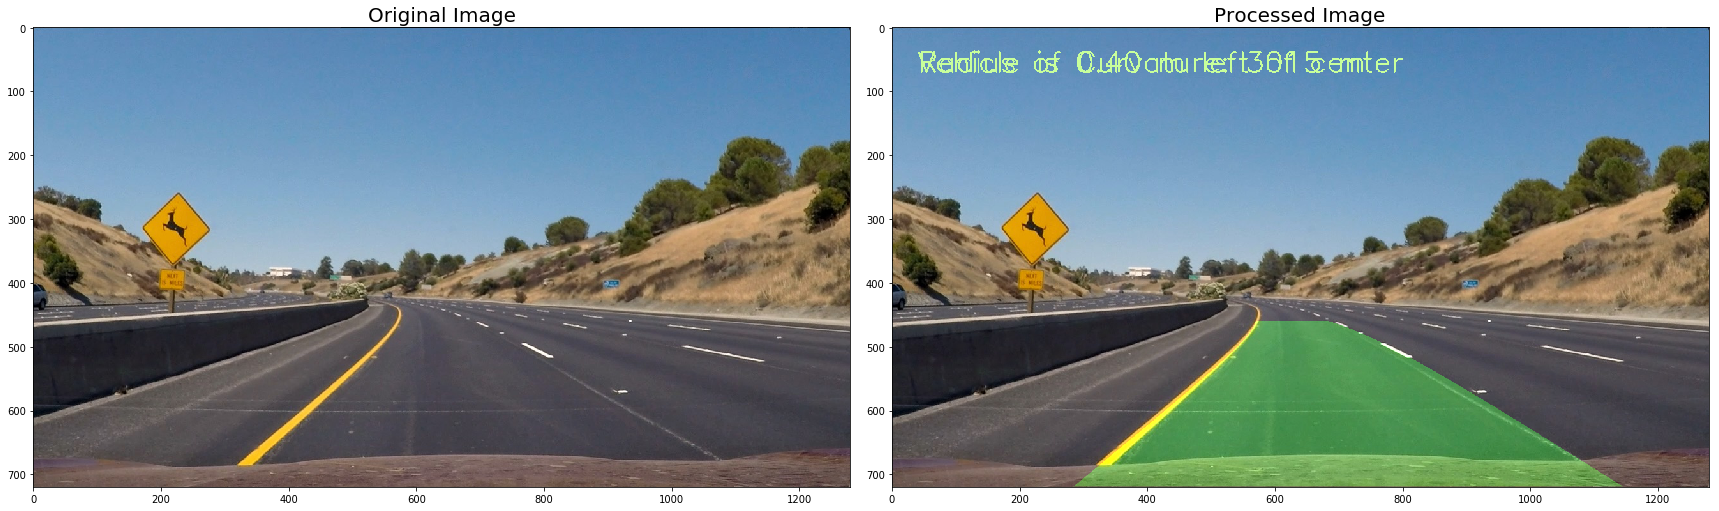

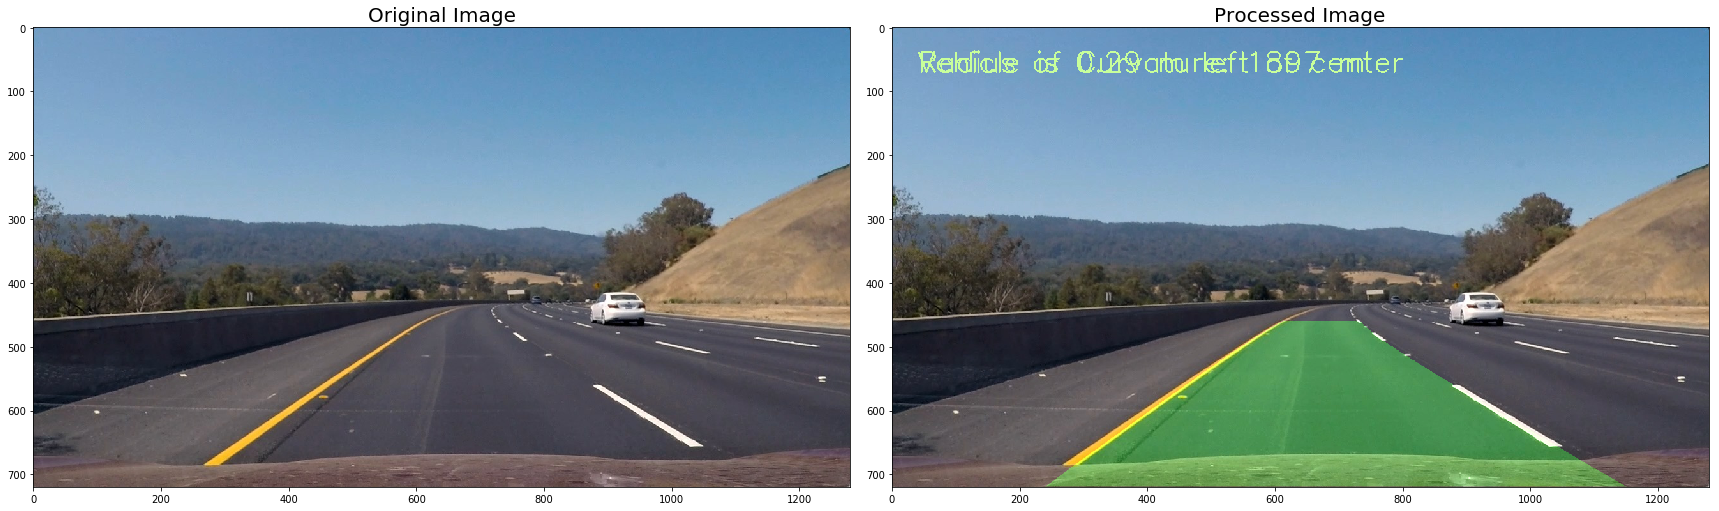

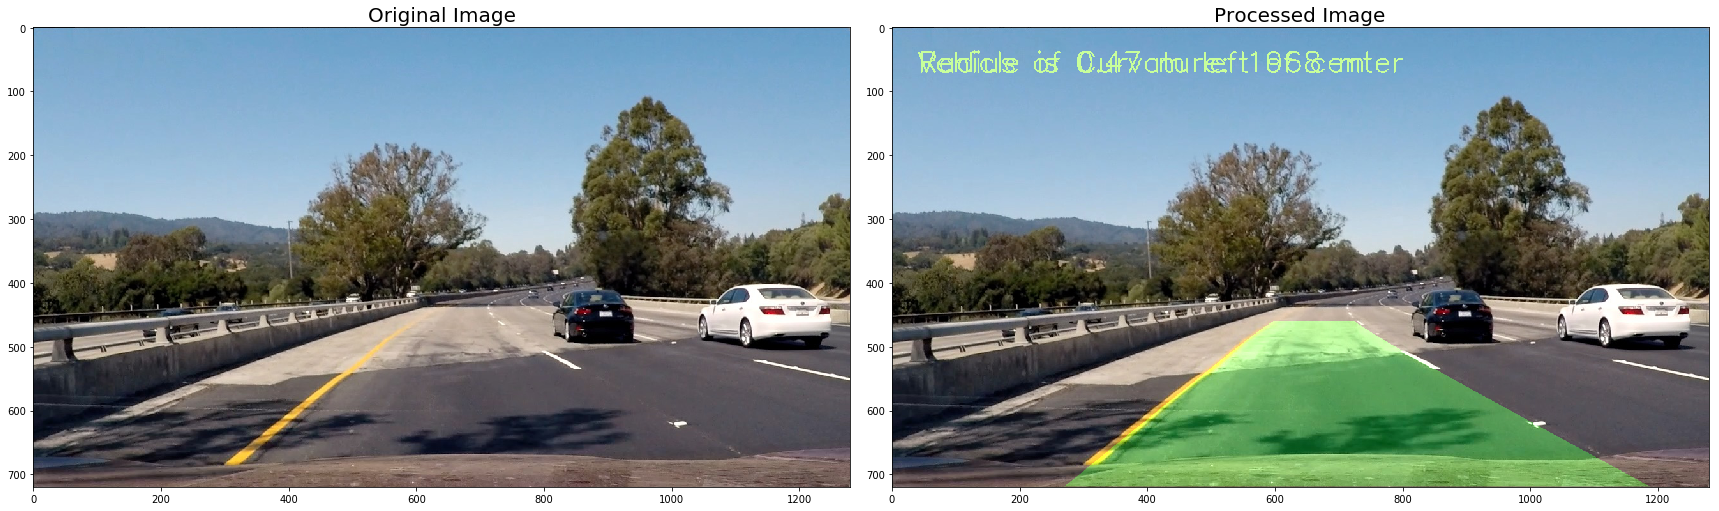

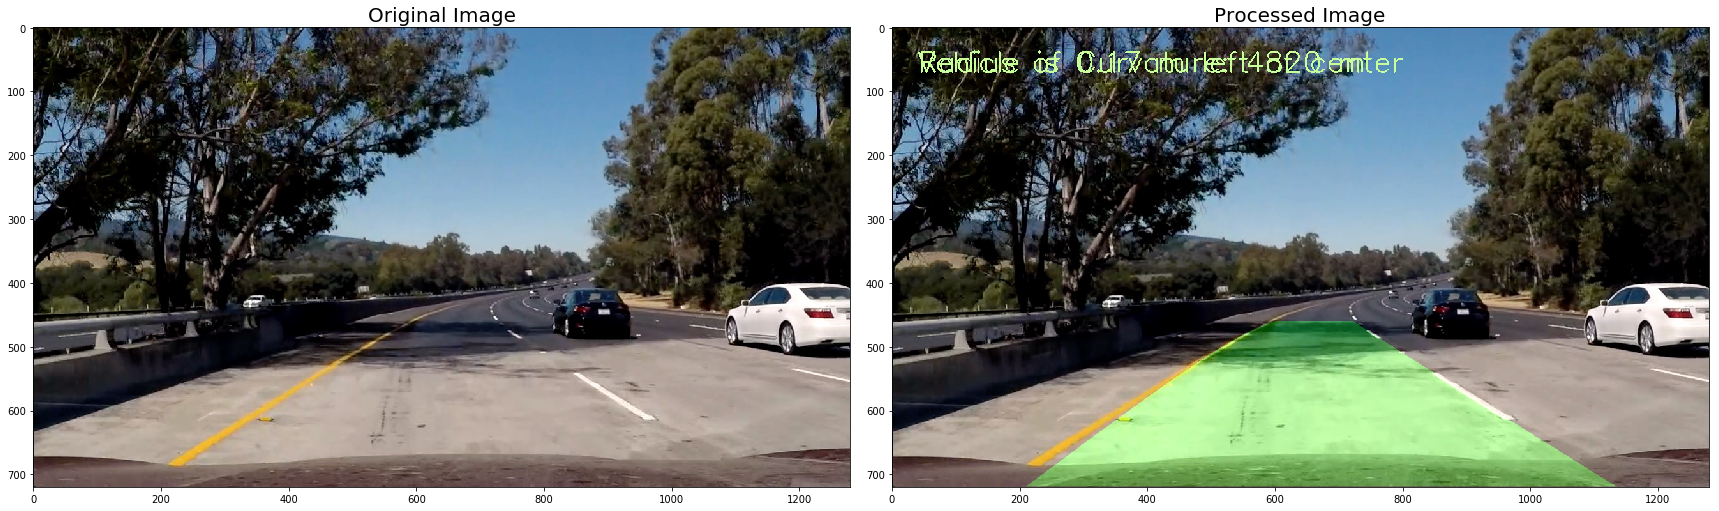

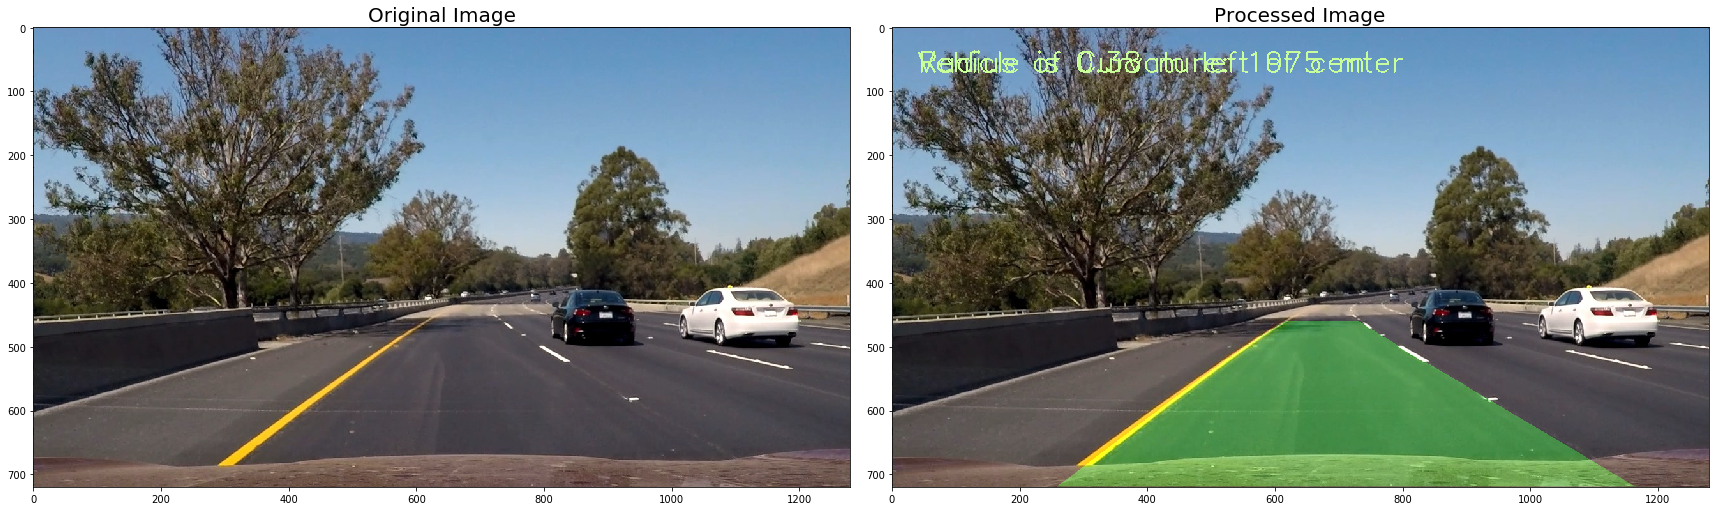

In [26]:
# Plot lines on images
x_values = [area_of_interest[0][0],area_of_interest[1][0],area_of_interest[2][0],area_of_interest[3][0],area_of_interest[0][0]]
y_values = [area_of_interest[0][1],area_of_interest[1][1],area_of_interest[2][1],area_of_interest[3][1],area_of_interest[0][1]]

# Plot example images and warp them
for i in range(1,7):
    # Set up lines for left and right
    left_lane = Line()
    right_lane = Line()
    # load the image
    fname = 'test_images/test{}.jpg'.format(i)
    img_raw = mpimg.imread(fname)    
    # Apply pipeline to the image to create black and white image
    img = process_image1(img_raw)
    # Unwrap the image
    top_down, perspective_M, perspective_Minv = corners_unwarp(img, nx, ny, mtx, dist)
    # plot
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.set_title('Original Image', fontsize=20)
    ax1.imshow(img_raw)
    # Set up lines for left and right
    left_lane = Line()
    right_lane = Line()    
    # Use the information from fit_lane function to color the lanes
    image_color = process_image1(img_raw)
    ax2.imshow(image_color)
    ax2.set_title('Processed Image', fontsize=20)

In [ ]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up classes for left and right lines
left_lane = Line()
right_lane = Line()
white_output = 'project_video_out_final.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image1) 
%time white_clip.write_videofile(white_output, audio=False)

In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
left_lane = Line()
right_lane = Line()
write_output = 'sample_out_improved.mp4'
subclip = VideoFileClip("project_video.mp4").subclip(41, 43)
write_clip = subclip.fl_image(process_image1) 
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video sample_out_improved.mp4
[MoviePy] Writing video sample_out_improved.mp4


 98%|█████████████████████████████████████████▏| 50/51 [00:50<00:01,  1.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sample_out_improved.mp4 

Wall time: 53.6 s


In [29]:
# draw detected lane lines on the video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
left_lane = Line()
right_lane = Line()
write_output = 'challenge_video_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
write_clip = clip1.fl_image(process_image) 
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|████████████████████████████████████████| 485/485 [11:53<00:00,  1.76s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

Wall time: 12min 8s


In [ ]:
# draw detected lane lines on the video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
write_output = 'harder_challenge_video_out.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
write_clip = clip1.fl_image(process_image) 
%time write_clip.write_videofile(write_output, audio=False)